In [4]:
%matplotlib inline
import os
import numpy as np
import glob
import PIL.Image as Image
from tqdm import tqdm_notebook as tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
# load pretrained model
from torchvision import models

## download built-in svhn data

In [106]:
# download if necessary
if not os.path.isfile('./data/train_32x32.mat'):
    # use as digital training set
    svhn_train_set = datasets.SVHN('./data',split='train',download=True, transform=transforms.ToTensor())
if not os.path.isfile('./data/test_32x32.mat'):
    # use as digital testing set
    svhn_test_set = datasets.SVHN('./data',split='test',download=True, transform=transforms.ToTensor())
if not os.path.isdir('./data/cifar-10-batches-py'):
    # use as non-digital training set
    cifar10_train_set = datasets.CIFAR10('./data',train=True,download=True,transform=transforms.ToTensor())
    # use as non-digital testing set
    cifar10_test_set = datasets.CIFAR10('./data',train=False,download=True,transform=transforms.ToTensor())
# # print dataset information
# print("svhn train:%d, svhn test:%d, cifar train:%d, cifar test:%d"%(len(svhn_train_set),
#                                                                     len(svhn_test_set),
#                                                                     len(cifar10_train_set),
#                                                                     len(cifar10_test_set)))

###############################
# dataset class
###############################
# combine train and test together
class PartySet(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path='./data'):
        'Initialization'
        self.transform = transform
        # load svhn
        self.svhn = datasets.SVHN(data_path,
                                  split='train' if train else 'test', 
                                  transform=transforms.ToTensor())
        self.cifar = datasets.CIFAR10(data_path,
                                      train = train,
                                      transform=transforms.ToTensor())
        # compute length
        self.l = len(self.svhn) + len(self.cifar)
        self.transform = transform
        
    def __len__(self):
        'Returns the total number of samples'
        return self.l

    def __getitem__(self, idx):
        'Generates one sample of data'
        if idx >= len(self.svhn):
            # load cifar part
            nidx = idx - len(self.svhn)
            X = self.cifar.data[nidx]
            y = 10 # new class, not digital
            #self.cifar.targets[nidx]
            X = Image.fromarray(X)
        else:
            # load svhn part
            X = self.svhn.data[idx]
            y = self.svhn.labels[idx]
            y = (y) if y < 10 else 0
            X = Image.fromarray(np.transpose(X, (1, 2, 0)))
        if self.transform is not None:
            X = self.transform(X)
            
        return X, y

In [107]:
trainset = PartySet(train=True, transform=transforms.ToTensor())

###############################
# mean, std: too slow, do once
###############################
# imgs_tensor = torch.stack([img_tensor for img_tensor, _ in trainset],dim=3)
# imgs_tensor = imgs_tensor.view(3,-1)
# mean = imgs_tensor.mean(dim=1)
# std = imgs_tensor.std(dim=1)
# print('mean:%s, std:%s'%(mean,std))
mean = [0.4597, 0.4595, 0.4623]
std = [0.2208, 0.2200, 0.2258]

# consider data augmentation if necessary
new_transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize(mean,std)])

trainset.transform = new_transform

testset = PartySet(train=False, transform=new_transform)

## data loader
batch_size = 64
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3)
test_loader = DataLoader(trainset, batch_size=batch_size, shuffle=False, num_workers=3)

## Visulization some data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([64])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

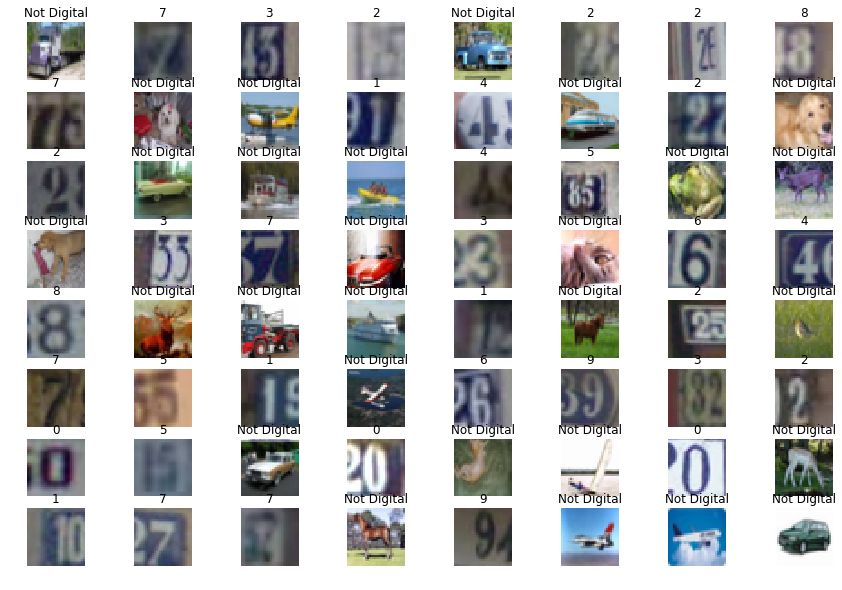

In [109]:
images, labels = next(iter(train_loader))
print(labels.shape)
plt.figure(figsize=(15,10))

label_name = ['0','1','2','3','4','5','6','7','8','9','Not Digital']

for i in range(64):
    plt.subplot(8,8,i+1)
    img = np.swapaxes(np.swapaxes(images[i].numpy(), 0, 2), 0, 1)
    img = img*std+mean
    plt.imshow(img)
    plt.title(label_name[labels[i].item()])
    plt.axis('off')


## Task-1: train a CNN for digits classification
TODO:
1. use a self-defined simple network
2. use pretrained lightweight network